[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/4-tables?labpath=10_-_Hypothesis_Testing.ipynb)


# Lecture 10: Hypothesis Testing
## Data Science for Historians (with Python)
### A very gentle and practical introduction
### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">

At this point in the course, to describe, summarize, and compare variables. What we lack at this point, is a more formal procedures to understand and assess the importance of the differences we observe in our data. For example, we established that men are, on average, one year younger than women. But how can we establish the value or 'significance' of these differences?

We move from descriptive to inferential statistics and continue with predictive modelling in the next notebooks.

For more background of the concepts and terminology used in this notebook, please consult the lecturer by Luke Blaxill.

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
sns.set()

We repeat some of the code from the previous notebook and load the synthethic census data.

In [58]:
df = pd.read_csv('data/icem/EW01_london_subsample.csv',index_col=0)

To make our analysis a bit more interesting and complex, we add a dimension: place. We study how the age differences between men and women vary depending on the registration district. In Pandas, adding subgroups is convenient: pass a list of with column namess `['RegDist','Sex']` instead of just one column as previously. `.groupby()` will read this list from left to right, i.e. groups the data first by place and then by sex.

In [59]:
by_reg_gen = df.groupby(['RegDist','Sex'])['Age'].mean()
by_reg_gen

RegDist        Sex
Bethnal Green  F      25.920963
               M      25.613501
               U      20.766603
Camberwell     F      27.986109
               M      26.708931
                        ...    
Whitechapel    M      26.254569
               U      24.051316
Woolwich       F      26.653639
               M      26.311769
               U      21.427165
Name: Age, Length: 90, dtype: float64

Working with output of this operation requires a bit more thought. The `.groupby()` arranges data slightly differently depending on whether you group on one column or more. This becomes apparent when printing the `type()` of the `.index` attribute.

In [62]:
type(df.groupby('Sex')['Age'].median().index)

pandas.core.indexes.base.Index

In [63]:
type(by_reg_gen.index)

pandas.core.indexes.multi.MultiIndex

`by_reg_gen` orders the data using `MultiIndex`, which means that there multiple levels (place and sex) via which we can access and organize our data.

Place is the highest level in our grouped data frame. We can access the seperate

In [71]:
by_reg_gen.loc['Bethnal Green']

Sex
F    25.920963
M    25.613501
U    20.766603
Name: Age, dtype: float64

Similarly, we can slice the data by place.

In [70]:
by_reg_gen.loc['Bethnal Green':'Chelsea']

RegDist        Sex
Bethnal Green  F      25.920963
               M      25.613501
               U      20.766603
Camberwell     F      27.986109
               M      26.708931
               U      23.410050
Chelsea        F      31.318046
               M      30.430615
               U      28.800000
Name: Age, dtype: float64

But our index has two level, place and sex. We can obtain the means for women using the following syntax.

In [69]:
by_reg_gen.loc[:,'F']

RegDist
Bethnal Green               25.920963
Camberwell                  27.986109
Chelsea                     31.318046
Fulham                      27.920645
Greenwich                   27.593689
Hackney                     28.796820
Hampstead                   29.742615
Holborn                     27.719117
Islington                   29.047747
Kensington                  30.823465
Lambeth                     29.019583
Lewisham                    28.879865
London City                 31.323944
Marylebone                  30.465945
Mile End Old Town           26.298023
Paddington                  30.450756
Pancras                     29.136537
Poplar                      26.384635
Shoreditch                  27.056387
Southwark                   27.144232
St George Hanover Square    30.821499
St George In The East       24.545266
St Giles                    30.129131
St Olave Southwark          26.486323
Stepney                     25.985841
Strand                      29.288732
Wand

Notice the comma between the square brackets after `.loc`: `by_reg_gen.loc[:,'F']`, 
- the part before the comma indicates the items we want to access from the first level (place). In this case we entered a colon, meaning from first to last.
- the part after the comma indicates the items we want to select from the second level. In this case we want retrieve all elements with key 'F'.

Computing the age differences by place is then fairly straightforward.

In [72]:
f_m_diff = by_reg_gen.loc[:,'F'] - by_reg_gen.loc[:,'M']
f_m_diff

RegDist
Bethnal Green               0.307461
Camberwell                  1.277178
Chelsea                     0.887431
Fulham                      1.295697
Greenwich                   0.971892
Hackney                     1.357030
Hampstead                   0.645606
Holborn                     0.341140
Islington                   1.430837
Kensington                  1.410332
Lambeth                     1.411260
Lewisham                    1.420661
London City                 3.262573
Marylebone                  0.921905
Mile End Old Town           0.599087
Paddington                  1.664367
Pancras                     1.031302
Poplar                     -0.218534
Shoreditch                  0.130194
Southwark                   0.101532
St George Hanover Square    1.412338
St George In The East      -0.011402
St Giles                   -0.879827
St Olave Southwark          0.088463
Stepney                    -0.334267
Strand                     -1.759558
Wandsworth                  1.

Of course you can be more restrictive, for example, slice the data by place and then only get observations for the 'F' label

In [73]:
by_reg_gen.loc['Bethnal Green':'Chelsea','F']

RegDist        Sex
Bethnal Green  F      25.920963
Camberwell     F      27.986109
Chelsea        F      31.318046
Name: Age, dtype: float64

## Hypothesis testing

At this stage, we can compute and compare distribution of variables, calculate their means or other relevant statistics. But a question than immediately appears: are the differences we observe "significant", and what do we mean with "significance" anyway. In this section we have a closer look at hypothesis testing from a data driven perspective.

Traditionally, statistical methods, such as the Student's t-test arose in times of limited computing power and relied often on theorems and assumptions about the distributions and their properties. Explaining this requires many detours and implies a steep learning for the statistically unitiated. 

In this lecture therefore focus in more data-driven and hopefully intuitive procedures for signficance testing. We will rely on what is called the *permutation precudure*. The question we first address regards the relation between Sex and Age in Whitechapel and Westminster. We observed in the previous section that both districts deviate from the general pattern, namely a slightly older female population.

In [74]:
df_whitechapel = df[df.RegDist=='Whitechapel']
df_westminster = df[df.RegDist=='Westminster']
df_whitechapel.shape, df_westminster.shape

((18772, 4), (8033, 4))

In [75]:
df_whitechapel.groupby('Sex')['Age'].agg([np.mean,np.std])

,mean,std
Sex,,
F,24.649451,17.392034
M,26.254569,17.384621
U,24.051316,17.402732


In [76]:
df_westminster.groupby('Sex')['Age'].agg([np.mean,np.std])

,mean,std
Sex,,
F,28.990447,17.394611
M,29.319512,17.356371
U,27.442879,15.662069


In the case of Whitechapel, the difference between the mean is a 1.3 years. 

But is this a "significant" difference? Can this difference be a random artefact of the data? Is the product of random chance? The latter will be our Null Hypothesis, namely that random chance explains the observed differences between the mean. The Alternate Hypothesis, is the "counterpoint" the Null Hypothesis, namely that the differences are **not** the result of random chance, and there exists a true age gap. It is by rejecting the null-hypothesis that we can accept that age difference are not random. In this sense we never prove Alternative Hypothesis directly, but assume it is true because the Null Hypothesis is clearly inconsistent with the data.

To repeat: The procedure we will following is trying "prove" that the Alternative Hypothesis is True by rejecting the Null Hypothesis. 

## Bootstrap: Distribution of a Sample Statistic

The statistic we computed give us an idea of the of expected age for residents in different registration districts. This is based on partial data, a subsection of Londoners at a particular point in time. This one statistic is, however, a weak emperical basis, and instead it is often useful to obtain a distribution of possible values, i.e. which means are consistent with the data, and which are unlikely to occur. Our estimate of the mean may contain error, and we'd like to compute. In other words we'd like to understand the distribution of the sample statistic. 

However we can not draw more subsamples from the sample we have. This technique is called bootstrapping: we randomly selected a set of obervations from our data, compute the mean, and put the observations back (with replacement). If we repeat this procedure for, let's say, 1000 times, we get an idea of which means are likely to emerge from our data, and which one are not.


In code it is very easy to implement this procedure. In the for loop, we randomly sample 100 observations, compute the mean, and store this statistic in `mean_sampled`. We repeat this procedure 100 times. 


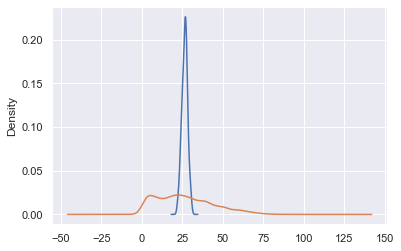

In [99]:
mean_sampled = []
for _ in range(100): # repeat code in block below 100 times
    sample = df_wh_M['Age'].sample(100) # randomly sample 100 observations
    mean_sampled.append(sample.mean()) # append mean of subsample
pd.Series(mean_sampled).plot(kind='density') # plot the sampling distribution a statistic
df_wh_M['Age'].plot(kind='density') # plot the original data distribution

In this figure we plot the sampling distribution of the statistic (blue) and the distribution original sample (orange). Notice how different these distributions look: the distribution of the sampling is narrower and centered around mean of the distribution (of the sampling statistic). The phenomenom is often referred to as the central limit theorem: the distribution of the sampling statistic (the mean) will converge to a normal distribution. "The mean drawn from multiple sample will resemble a 'normal distribution' which is a bell shaped function, with most of the values within two standard deviations from the mean. Again, here we are not really obtaining new sample, but bootstrapping means by subsampling the data we have. However, the result are largely identitical and this provides a data-driven method for computing the distribution of sampling statistics.

In this lecture, which is practical and not theoretical, we will skip the formal proof and just simulate what happens. In the figure belowe we increase the number of iteration and the size of subsample and plot the mean and standard deviations. You notice that values (means for male in westminster) two standard deviations from the mean are unlikely to occur. The mean age, based on our bootstrap, is likely to fall between 25.21 and 27.25

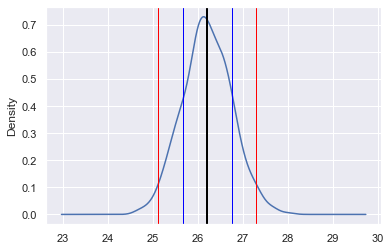

In [119]:
mean_sampled = []
for _ in range(1000): # repeat code in block below 100 times
    sample = df_wh_M['Age'].sample(1000) # randomly sample 100 observations
    mean_sampled.append(sample.mean()) # append mean of subsample
ax = pd.Series(mean_sampled).plot(kind='density') # plot the sampling distribution a statistic
ax.axvline(x = pd.Series(mean_sampled).mean(), color='black', lw=2) # plot mean of distribution of the sampling statistic
ax.axvline(x = pd.Series(mean_sampled).mean() + pd.Series(mean_sampled).std(), color='blue', lw=1) # plot one standard deviation from the mean
ax.axvline(x = pd.Series(mean_sampled).mean() - pd.Series(mean_sampled).std(), color='blue', lw=1) # plot one standard deviation from the mean
ax.axvline(x = pd.Series(mean_sampled).mean() + (2*pd.Series(mean_sampled).std()), color='red', lw=1) # plot two standard deviations from the mean
ax.axvline(x = pd.Series(mean_sampled).mean() - (2*pd.Series(mean_sampled).std()), color='red', lw=1) # plot tow standard deviation from the mean

This approach gives us a more accurate way of establishing the significance of the differences: assuming there is no difference betweem men and women with respect to their age,  what's the probability of observing the mean age for women in the distribition of the sampling mean computed for men? You'll notice that even though the actual distribution of age by sex looks fairly similar, when we computing the distribution of the sampling mean, the difference become strikingly apparent, there is hardly any overlap between the two bell shaped curves, and more importantly the sampling mean for women is more than two standard deviations from the sampling mean of men.

In this sense, the difference seem significant (even though they remain fairly small).

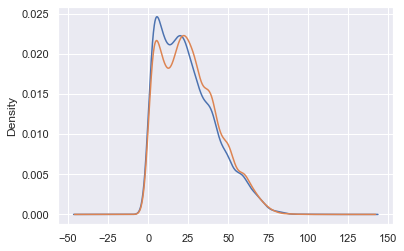

In [126]:
df_wh_F.Age.plot(kind='density')
df_wh_M.Age.plot(kind='density')

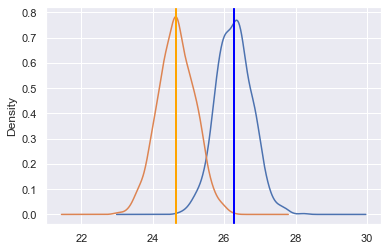

In [127]:
mean_sampled_m = []
mean_sampled_f = []
for _ in range(1000): # repeat code in block below 100 times
    mean_sampled_m.append(df_wh_M['Age'].sample(1000).mean())
    mean_sampled_f.append(df_wh_F['Age'].sample(1000).mean()) 
ax = pd.Series(mean_sampled_m).plot(kind='density') 
pd.Series(mean_sampled_f).plot(kind='density') 
ax.axvline(x = pd.Series(mean_sampled_m).mean(), color='blue', lw=2)
ax.axvline(x = pd.Series(mean_sampled_f).mean(), color='orange', lw=2)

In [146]:
len([i for i in mean_sampled_m if i >= pd.Series(mean_sampled_f).mean()]) 

1000

Another way to approach significance, is the idea that differences between men and women are unlikely to be zero, which is tested using the code below.

In [153]:
df_wh_F.shape,df_wh_M.shape

((8655, 4), (9357, 4))

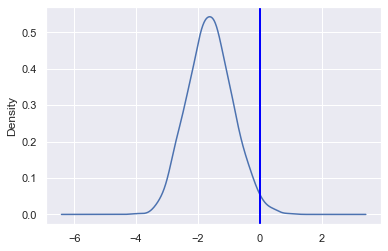

In [167]:
mean_sampled_diff = []

for _ in range(1000): # repeat code in block below 100 times
    mean_sampled_diff.append(df_wh_F['Age'].sample(1000).mean() - df_wh_M['Age'].sample(1000).mean())
    
ax = pd.Series(mean_sampled_diff).plot(kind='density') 
ax.axvline(x = 0, color='blue', lw=2)


Using quantiles, we conmpute the 95% confidence intervals using the distribution of the sampling statistic. This tells us that in 95% of the cases mean difference between men and women will be -3.017025 and -0.179900, and therefore is unlikely to include zero. The probability that there is no difference is therefore smaller than 0.05 (the traditional threshold for rejecting the null-hypothesis in favour of the alternative hypothesis.

In [174]:
pd.Series(mean_sampled_diff).quantile([0.025,0.975])

0.025   -2.929675
0.975   -0.174625
dtype: float64

## Permutation

Another approach to establish significance in more data-driven way (without relying on abstract proof or statistical theory) is the permutation test. The bootstrap treats the actual sample as the population and from which it draws examples to compute statistics that could have occurred. Instead of using just one estimate, we created a distribution of sample statistics (each based on a subsection of our data). 

The permutation follows a slightly different procedure, but also involves resampling from our data. Let's establish wether the age differences we observe between men and women living in Whitechapel are statistically significant. 

1: we note the number of observations we have for each of our categories of interest (i.e. the number of women and men present in the data frame). Let call these two groups `M` and `F` for convenience. 

2: we combine the results into one data frame, which embodies the null-hypothesis that, when it comes to age, mean and women can be treated as the same belonging to the same group.

3: we shuffle the combined dataset (which mean randomizing the order of the rows) and take a sample that has the same number of observations as `F` (notice that this will contain data from both `M` and `F`.

4: we take second is sample (i.e, what what's left over after taken our the number of observations of `len(F)`

5: now, we compute the mean for each sample and take difference, and record this number

6: repeast step 2 till 5 a number times, let's say 1000, which will generate a distribution of permutation statistics.

Let's implement this procedure in code. First we create three data frames, in this case we use another registration district, Poplar. But we recommend to repeat the analysis below for Whitechapel or any other borough.

In [261]:
regdist = 'Poplar'
df_sub_F = df[(df.Sex=='F') & (df.RegDist==regdist)]
df_sub_M = df[(df.Sex=='M') & (df.RegDist==regdist)]
df_sub_C = df[df.Sex.isin(['F','M']) & (df.RegDist==regdist)] 

In [262]:
df_sub_F.shape,df_sub_M.shape, df_sub_C.shape

((19993, 4), (19376, 4), (39369, 4))

For Poplar we observe that means between the sexes differ with approximately 0.2 years (women being younger) than men. Is this result of random chance? What is the probability of observing this difference if there existed no difference for this borough?

In [263]:
df_sub_F['Age'].mean(),df_sub_M['Age'].mean()

(26.38463462211774, 26.603168868703552)

In [264]:
df_sub_F['Age'].mean() - df_sub_M['Age'].mean()

-0.21853424658581133

To answer this question, we've combined the observations for `F` and `M` in one data frame and .

In [265]:

num_F = df_sub_F.shape[0] # the number of observations for women
all_idx = set(df_sub_C.index) # get all indices

In [273]:
permutations = [] # initiate empty list to collect permutation statistics

for _ in tqdm(range(5000)): # we use tqmd to print the progress, running the permutation test can take a while
    f_idx = set(df_sub_C.sample(num_F).index) # take sample of size num_F and get index
    m_idx = all_idx - f_idx # get the remaining indices (rows not f_idx)
    diff_f_m_perm = df_sub_P.loc[f_idx]['Age'].mean() - df_sub_P.loc[m_idx]['Age'].mean() # diff between permuted statistics
    permutations.append(diff_f_m_perm) # append permutation statistic

Now we can plot the distribution of the permutation statistics, which indicates that if we don't assume any age differences between men and women in Poplar is likely between -0.6 and 0.6.

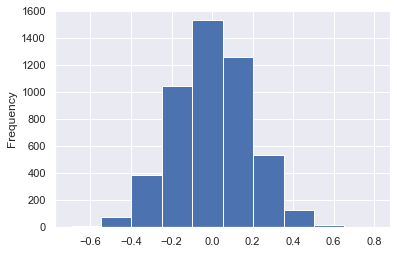

In [276]:
pd.Series(permutations).plot(kind='hist')

The observed difference was -0.2 which is well the range of what we'd expect if the Null-hypothesis were True. In this case we don't have enough evidence to reject the null-hypothesis. 

Text(0, 0.5, 'Frequency')

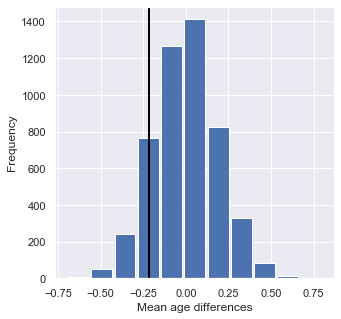

In [277]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(permutations, bins=11, rwidth=0.9)
ax.axvline(x = df_sub_F['Age'].mean() - df_sub_M['Age'].mean(), color='black', lw=2)
ax.set_xlabel('Mean age differences')
ax.set_ylabel('Frequency')

In this figure we compare the observed difference with distribution of the permuted differences. The black line shows the difference between the means we computed earlier. You'll notice that this values is well within the set of permuated values. In other words, we don't have enough evidence to reject the null-hypothesis, that the observed difference is product of chance.

In [278]:
np.mean(np.array(permutations) < (df_sub_F['Age'].mean() - df_sub_M['Age'].mean()))

0.1246

We can not reject the null-hypothesis, because there is quite a high probability, namely 0.13 that we observe a mean difference of -0.2 when we assume there is no difference between men and women in Poplar, and the observed age gap may therefore be a product of chance.

In [280]:
len([i for i in permutations if i < df_sub_F['Age'].mean() - df_sub_M['Age'].mean()]) / len(permutations)

0.1246

The result of the permuation test is largely similar to the Student's t-test. The p-value in this case is the probability of observed values equal to or lower than the observed difference, assuming there is no difference between men amd womenin the sample (a one-side t-test)

In [282]:
from scipy.stats import ttest_ind
ttest_ind(df_sub_F['Age'],df_sub_M['Age'],alternative='less')

Ttest_indResult(statistic=-1.151420997318941, pvalue=0.12478303628250077)

You can repeat the permutation for Whitechapel and in this case the age difference should be highly significant.

## Gender and Disability
### an example

We can also use permutation to test the relation between categorical variables: in this case we study the relation gender and disability as reported in our census sample.

In [366]:
p = df.groupby('Sex')['Disability'].agg([np.sum, len])

AttributeError: 'int' object has no attribute 'groupby'

In [ ]:
p['no_disability']  = p['len'] - p['sum']

In [ ]:
p.rename({'sum':'disability','len':'all'},axis=1,inplace=True)

In [ ]:
p_t = p.T
p_t

In [ ]:
p_t.loc[['disability','no_disability'],['F','M']]

In [ ]:
import random
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [352]:
obs_f = p_t.loc['disability','F'] / p_t.loc['all','F']
obs_m = p_t.loc['disability','M'] / p_t.loc['all','M']

In [354]:
obs_pct_diff = 100 * (obs_f - obs_m)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: -0.0426%


In [355]:
conv = [0] * (p_t.loc['no_disability','F']+p_t.loc['no_disability','M'])
len(conv)

1060172

In [361]:
conv.extend([1] * (p_t.loc['disability','F']+p_t.loc['disability','M']))
conv_series = pd.Series(conv)
conv_series

0          0
1          0
2          0
3          0
4          0
          ..
1073916    1
1073917    1
1073918    1
1073919    1
1073920    1
Length: 1073921, dtype: int64

In [ ]:
perm_diffs = [100 * perm_fun(conv_series,  p_t.loc['all','F'],  p_t.loc['all','M']) for _ in tqdm(range(1000))]

Text(0, 0.5, 'Frequency')

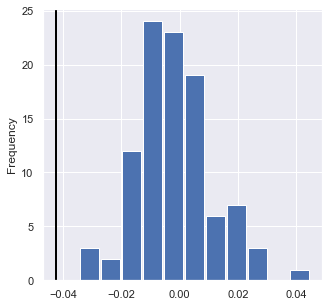

In [364]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.set_ylabel('Frequency')

In [367]:
from scipy import stats
survivors = np.array([[p_t.loc['disability','F'], p_t.loc['no_disability','F']], 
                      [p_t.loc['disability','M'], p_t.loc['no_disability','M']]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)
print(f'p-value : {p_value*2 / 2:.8f}')
chi2

p-value : 0.00087221


11.080911369410547

# Fin.